## Library Imports

In [2]:
%load_ext autoreload 
%autoreload 2
import os
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
from raggie import embedder, vecdb, retriever, raggy, utils

nest_asyncio.apply()
clear_output()

In [ ]:
QDRANT_HOST = os.getenv("QDRANT_HOST", "localhost")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", 6333))
OLLAMA_BASE_URL = os.getenv("OLLAMA_HOST", "http://localhost:11434")

## Traditional RAG

- In the previous code, the heavy lifting was happening behind the scenes:
    - llama-index taking care of the chunking and embedding part 
    - qdrant taking care of the indexing the embeddings and storing them 
    - llama-index taking care of retrieving the embeddings from the vector db 
    - llama-index also faciliated the reranking step for us 
    
- However, in this nb session, we would like to handle some bits ourselves:
    - Creation of embeddings 
    - Indexing is still taken care by Qdrant, we just tune it 
    - Retrieval of context from vectorDB 
    - Combining the above 3 steps, to create a simple end to end RAG pipeline

- As we are building the components ourselves step by step, we will see, where can we do the optimizations to improve the speed of the RAG system 

### Dataset Preparation

In [ ]:
from datasets import load_dataset

## Step 1: Load the SQuAD dataset
dataset = load_dataset("squad")

## Step 2 : Extract unique contexts from the dataset
data = [item["context"] for item in dataset["train"]]
texts = list(set(data))

### Embed Dataset
- EmbedData does the job of loading the embedding model & embedding the dataset & storing them 
- With the class instance, we will embed the dataset 

In [ ]:
batch_size = 32
embeddata = embedder.EmbedData(batch_size=batch_size)
embeddata.embed(texts)

In [ ]:
len(embeddata.embeddings[0])

In [ ]:
(
    utils.pretty_print(embeddata.contexts[0]),
    utils.pretty_print(embeddata.embeddings[0]),
)

### Vector DB
- QdrantVDB will help us interact with the vector DB. 


In [ ]:
database = vecdb.QdrantVDB(
    collection_name="dummy", vector_dim=1024, batch_size=512
)
database.define_client()
database.create_collection()
database.ingest_data(embeddata)
clear_output()

### Retrieval

- Encapsulate the logic for searching the vector db using a query (of string type)
- Using the embedding model and vector db, we can retrieve the most relevant contexts based on the query.

In [ ]:
print(database.client.count(collection_name="dummy"))

In [ ]:
result = retriever.Retriever(database, embeddata).search("Sample Query")

In [ ]:
for data in result.points:
    utils.pretty_print(dict(data)["payload"]["context"])


### RAG

- Essentially we will club the retriever with the LLM to wrap up the pipeline 
- The retriever in itself wraps up the embedder and the vector DB functionalities 


### Using RAG

In [ ]:
rv = retriever.Retriever(database, embeddata)
rag = raggy.RAG(rv)


# Taking a look at dummy data, and forming a query based on it
utils.pretty_print(embeddata.contexts[0])

In [ ]:
query = "What are some of the techniques used to study bird migration routes?"
context, response = rag.query(query)

In [ ]:
# utils.pretty_print(context)
utils.pretty_print(response)


### Binary Quantization Optimizations 

- In binary quantization, we convert positive and negative values to 1s and 0s
- Because of this 2 things happen:
    - We reduce the size of the vector embeddings by 4x (float32 to binary)
    - We can use bitwise operations to calculate similarity which are much faster 
    than floating point operations
- Below are few visualizations showcasing the quantizations, showing how still 
there is presence of data to be interpretted after quantization

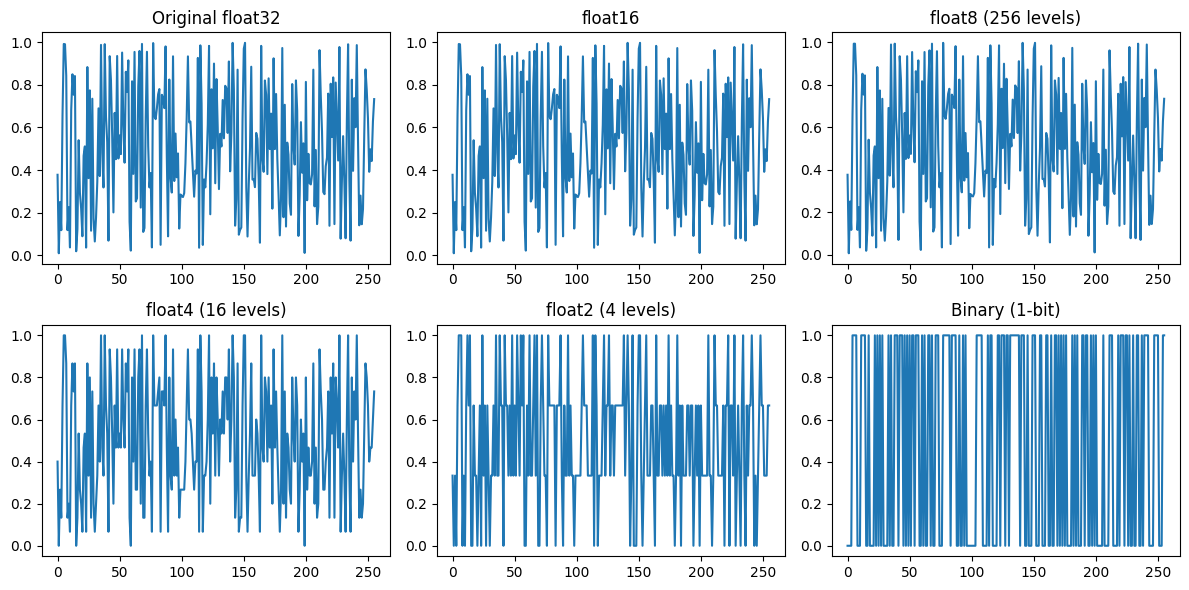

In [3]:
# -----------------------------
# 1. Create a float32 "image"
# -----------------------------
img_f32 = np.random.rand(1, 256)  # values in [0, 1]
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(img_f32[0])
plt.title("Original float32")

# -----------------------------
# 2. Convert to float16
# -----------------------------
img_f16 = img_f32.astype(np.float16)
plt.subplot(2, 3, 2)
plt.plot(img_f16[0])
plt.title("float16")

# -----------------------------
# 3. Quantize to "float8" (256 levels)
# -----------------------------
levels8 = 256
img_f8 = np.round(img_f32 * (levels8 - 1)) / (levels8 - 1)
plt.subplot(2, 3, 3)
plt.plot(img_f8[0])
plt.title("float8 (256 levels)")

# -----------------------------
# 4. Quantize to "float4" (16 levels)
# -----------------------------
levels4 = 16
img_f4 = np.round(img_f32 * (levels4 - 1)) / (levels4 - 1)
plt.subplot(2, 3, 4)
plt.plot(img_f4[0])
plt.title("float4 (16 levels)")

# -----------------------------
# 5. Quantize to "float2" (4 levels)
# -----------------------------
levels2 = 4
img_f2 = np.round(img_f32 * (levels2 - 1)) / (levels2 - 1)
plt.subplot(2, 3, 5)
plt.plot(img_f2[0])
plt.title("float2 (4 levels)")

# -----------------------------
# 6. Quantize to binary (1-bit)
# -----------------------------
img_bin = (img_f32 >= 0.5).astype(np.float32)
plt.subplot(2, 3, 6)
plt.plot(img_bin[0])
plt.title("Binary (1-bit)")

plt.tight_layout()
plt.show()


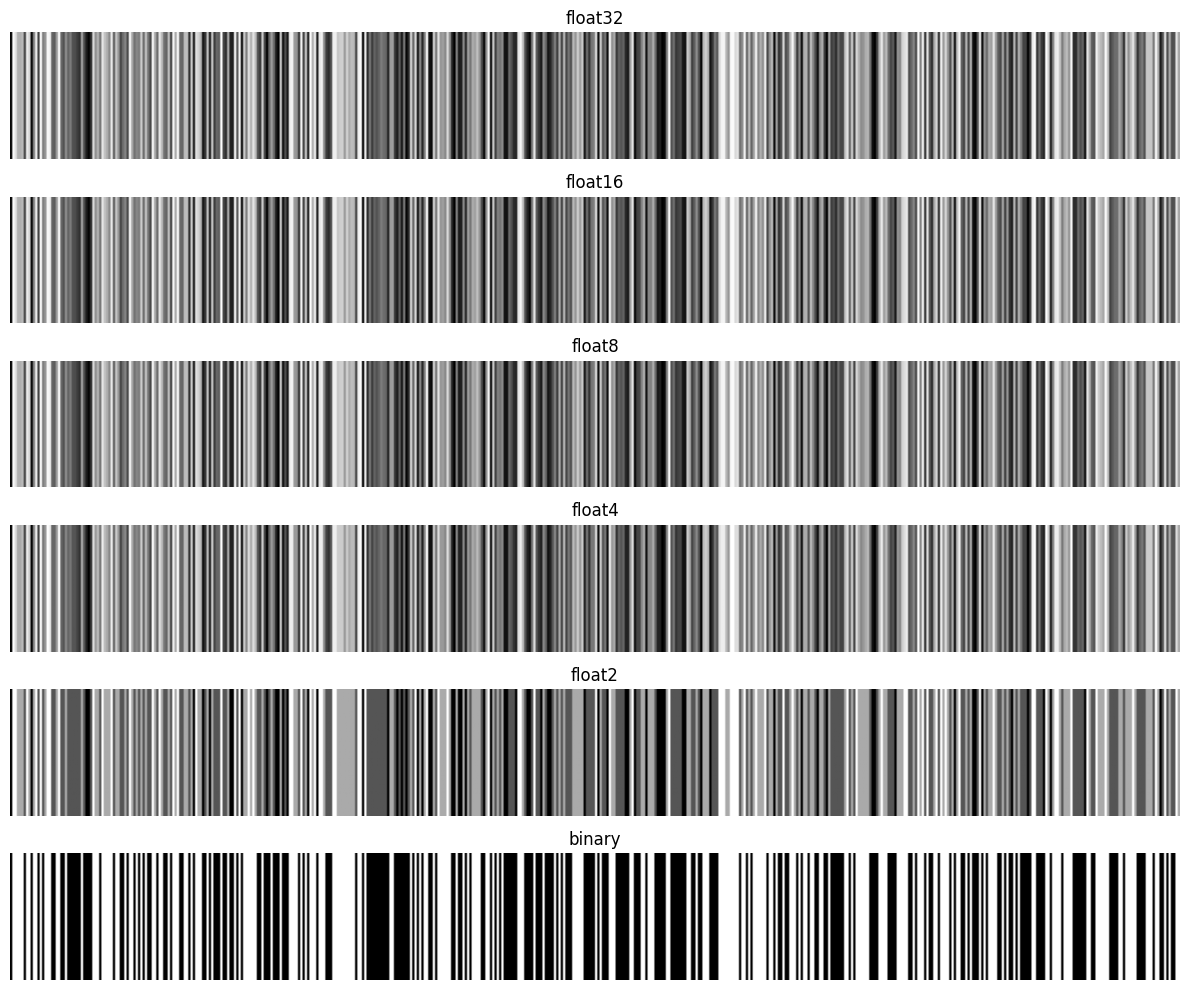

In [4]:
# NOTE: Black means 0, White means 1, white represents
# higher values/ essential information.
# -----------------------------
# 1. Create a random vector (float32)
# -----------------------------
vector = np.random.rand(1, 512).astype(np.float32)


# -----------------------------
# 2. Define quantization function
# -----------------------------
def quantize_vector(vec, levels):
    return np.round(vec * (levels - 1)) / (levels - 1)


# -----------------------------
# 3. Create all quantized versions
# -----------------------------
vector_f32 = vector.copy()
vector_f16 = vector.astype(np.float16)
vector_f8 = quantize_vector(vector, 256)
vector_f4 = quantize_vector(vector, 16)
vector_f2 = quantize_vector(vector, 4)
vector_bin = (vector >= 0.5).astype(np.float32)

vectors = [
    vector_f32,
    vector_f16,
    vector_f8,
    vector_f4,
    vector_f2,
    vector_bin,
]
titles = ["float32", "float16", "float8", "float4", "float2", "binary"]

# -----------------------------
# 4. Plot heatmaps in a single column (6 rows × 1 col)
# -----------------------------
plt.figure(figsize=(12, 10))

for i, (v, t) in enumerate(zip(vectors, titles)):
    plt.subplot(6, 1, i + 1)  # <-- 6 rows, 1 column
    plt.imshow(v, aspect="auto", cmap="grey")
    plt.title(t, fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


- To perform the binary quantization, we have to modify bits at 2 places: 
    - In the vector DB, we add a quantization config, to quantize the data during storage
    - In retriever code, when we are searching the params for quantization, we change ignore from True to False

- After these changes, we will now be quantizing the vectors during storing and retrieval 


In [ ]:
# Initialize the new vector DB with binary quantization
bq_database = vecdb.QdrantVDB(
    collection_name="bq_dummy", vector_dim=1024, batch_size=512, bq=True
)
bq_database.define_client()
bq_database.create_collection()
bq_database.ingest_data(embeddata)


# Retriever with binary quantization
retriever_bq = retriever.Retriever(bq_database, embeddata, bq=True)

# RAG with binary quantization
rag = raggy.RAG(retriever_bq)

clear_output()


In [ ]:
query = "What are some of the techniques used to study bird migration routes?"
context, response = rag.query(query)

In [ ]:
# utils.pretty_print(context)
utils.pretty_print(response)

### Limitations of Binary Quantization:
- Loss of Precision: Binary quantization reduces the precision of the original data, 
which can lead to a loss of important information, especially in complex datasets.     
- Reduced Model Performance: Models that rely on high-precision data may experience
a drop in performance when using binary quantized inputs, as they may not capture 
the nuances present in the original data.
- The performance of binary quantization highly depends on the inital embeddings produced by the embedding model, if the embeddings are not well-optimized, quantization, may exacerbate inaccuracies.  

### Minimizing the limitations 
- To minimize the limitations, we can oversample the vectors during the retrieval process, to gather more context for answering the QnA
- Use the embedding models which produce high quality embeddings as well as long embeddings, as high quality embeddings ensure less loss in information after quantization. Also long embeddings account, that each dimension carries less information, so quantization wont' hurt that much loss of information. But yup it's always a trade-off between the vector length occupying more space too. 

### Summary 
- In general we saw the traditional rag setting in this nb, what is happening behind the scenes in a traditional RAG pipeline such as: 
    - An embedding part, necessary for generating text embeddings from the context. 
    - A vector db, handling efficient storage of the embeddings 
    - A retriever to retrieve contexts by making use of the query embedding and the vector db 
    - Lastly the use of LLM with the above bits, to return to user an answer based on the retrieved context 